In [88]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming
import os
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3).set(title=title)

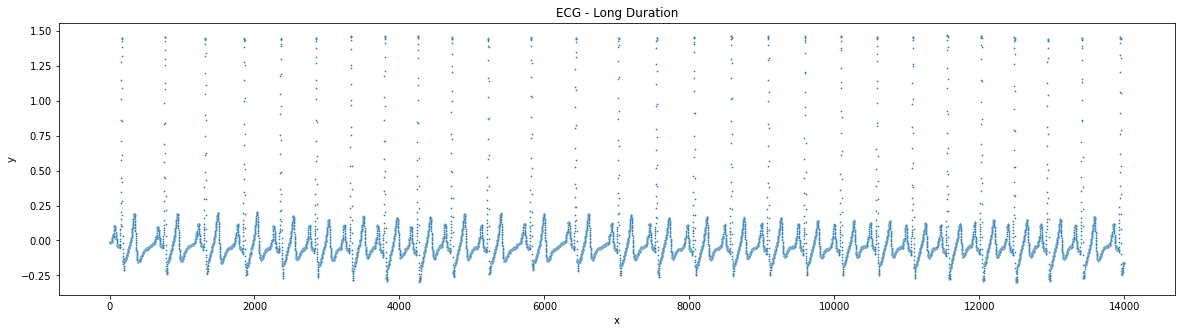

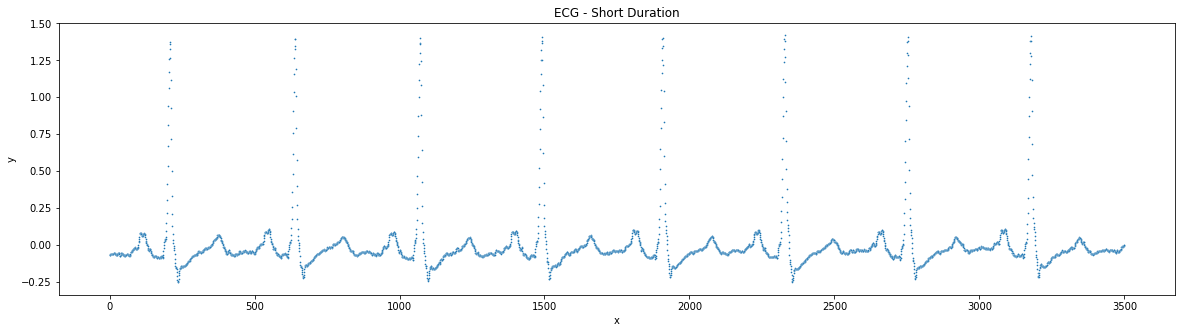

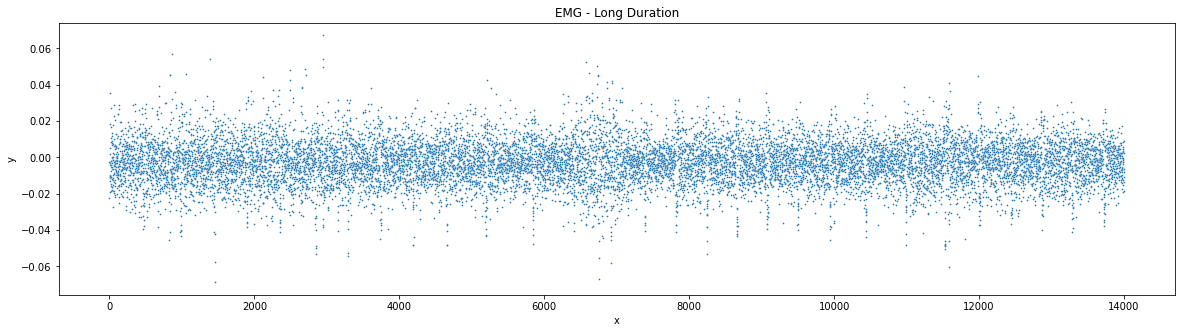

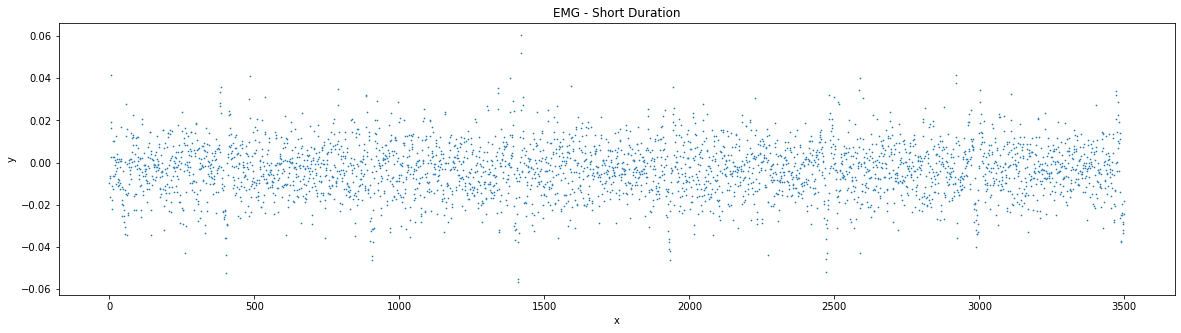

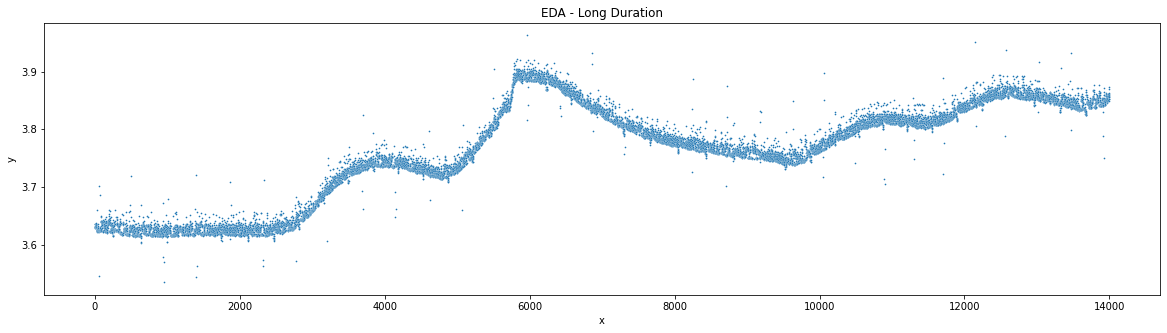

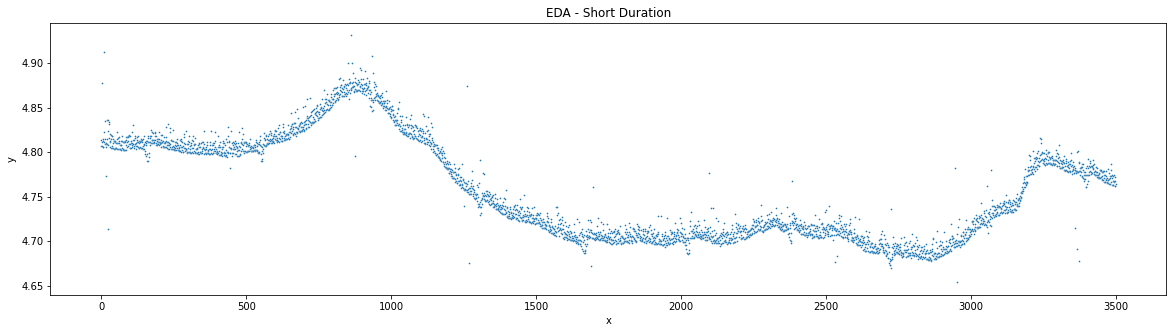

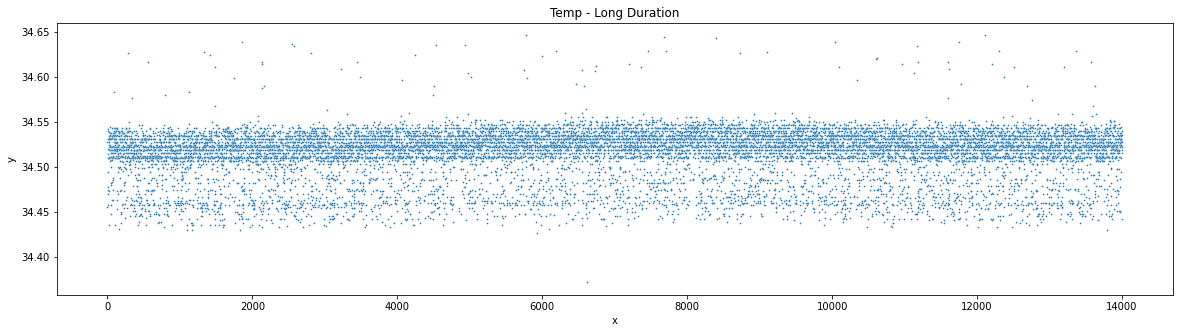

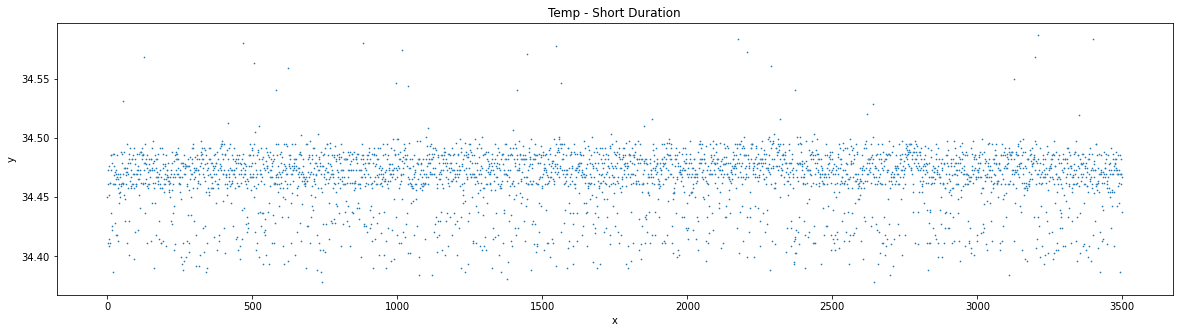

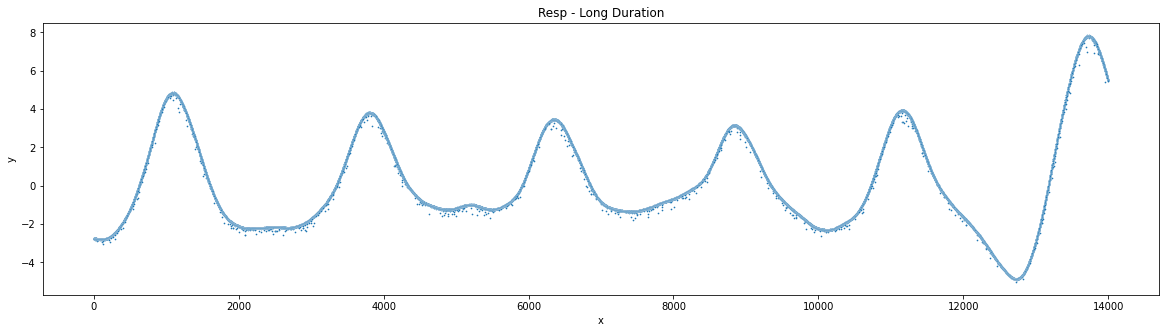

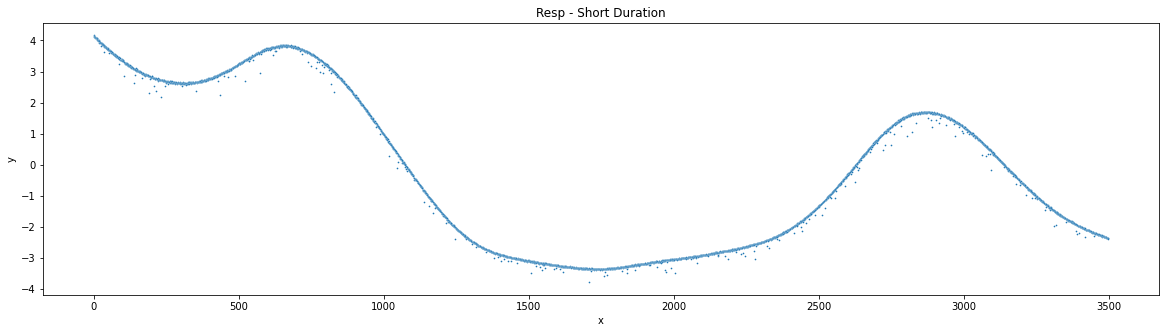

In [5]:
# Visualize the different chest signals for a random subject

SAMPLING_RATE = 700
LONG_DURATION = 20
SHORT_DURATION = 5

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, LONG_DURATION, SAMPLING_RATE, signal_type + ' - Long Duration')
    visualize_raw(signal, SHORT_DURATION, SAMPLING_RATE, signal_type + ' - Short Duration')

In [6]:
# Get additional notes for the Subjects

for subject in SUBJECTS :
    with open(PATH + 'S' + subject + '/S' + subject + '_readme.txt', 'r') as file :
        print(subject, file.readlines()[16])

2 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.

3 During the baseline condition, the subject was sitting in a sunny workplace.

4 -

5 Subject might have fallen asleep during the first meditation.

6 Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

7 -

8 Subject had already a rather stressful day, prior to the study.

9 -

10 -

11 -

13 -

14 -

15 Subject didn't really believe the cover story of the stress condition (TSST).

16 Subject felt rather cold in the room where the stress condition was carried out.

17 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [7]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10

In [8]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [9]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]   
    return np.array(features)

In [10]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    print(np.shape(feature_mean))
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [11]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [12]:
# Get Joint test-train  Datasets combining all signals

def get_chest_signal_dataset(subjects, signal_types = CHEST_SIGNALS) :
    combined_subject_features = {}
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_features = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in signal_types :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_features[label].append(features)
                
        for label in subject_features :
            subject_features[label] = np.stack(subject_features[label], axis = -1)
            
        aggregate_subject_features = []
        aggregate_subject_labels = []
            
        for label, features in subject_features.items() :
            for feature in features :
                aggregate_subject_features.append(feature)
                aggregate_subject_labels.append(label)
                
        feature_mean = np.mean(aggregate_subject_features, axis=0)
        feature_std = np.std(aggregate_subject_features, axis=0)
        
        aggregate_subject_features = np.array(aggregate_subject_features) - feature_mean
        aggregate_subject_features = np.divide(aggregate_subject_features, feature_std, out=np.zeros_like(aggregate_subject_features), where=feature_std!=0)
                
        combined_subject_features[subject] = {
            'features' : aggregate_subject_features,
            'labels' : aggregate_subject_labels
        }

    return combined_subject_features

In [13]:
def generate_dataset(combined_subject_features, subjects) :
    features_dataset = []
    labels_dataset = []
    
    for subject in subjects :
        features_dataset += list(combined_subject_features[subject]['features'])
        labels_dataset += combined_subject_features[subject]['labels']
        
    return np.array(features_dataset), np.array(labels_dataset)

In [14]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [15]:
combined_subject_features = get_chest_signal_dataset(SUBJECTS)

In [139]:
train_features, train_labels = generate_dataset(combined_subject_features, ['8', '15', '16', '3', '4', '5', '6', '7', '11', '13', '14', '10', '17', '9'])
test_features, test_labels = generate_dataset(combined_subject_features, ['2'])

In [140]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights /= np.min(class_weights)
d_class_weights = dict(enumerate(class_weights))

In [141]:
train_labels = encode_labels(train_labels)
test_labels = encode_labels(test_labels)

In [142]:
checkpoint_filepath = '../Models/Tmp.hdf5'

In [143]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.Conv2D(4, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(4, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [144]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(4, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish', depth_multiplier=2),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(4, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.Conv2D(5, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(5, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=5,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [145]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.SpatialDropout2D(0.4),
    keras.layers.Conv2D(8, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=12,  activation='swish'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=8,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

In [262]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(3,1), activation='swish'),
    keras.layers.SpatialDropout2D(0.4),
    keras.layers.Conv2D(6, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(units=12,  activation='swish'),
    keras.layers.Dense(units=6,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

# Khubb bhalo

In [315]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10, 2, 5)),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish', depth_multiplier=2),
    keras.layers.DepthwiseConv2D(kernel_size=(2,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(1, 1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.DepthwiseConv2D(kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(3,1), activation='swish'),
    keras.layers.Conv2D(8, kernel_size=(1,2), activation='swish'),
    keras.layers.Conv2D(4, kernel_size=(2,1), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(units=12,  activation='swish'),
    keras.layers.Dense(units=4, activation='softmax')
])

# Khubb bhalo

In [316]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_219 (Depthw (None, 9, 2, 10)          30        
_________________________________________________________________
depthwise_conv2d_220 (Depthw (None, 8, 2, 10)          30        
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 8, 2, 6)           66        
_________________________________________________________________
depthwise_conv2d_221 (Depthw (None, 6, 2, 6)           24        
_________________________________________________________________
depthwise_conv2d_222 (Depthw (None, 4, 2, 6)           24        
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 2, 2, 6)           114       
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 2, 1, 8)         

In [317]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [318]:
print(np.shape(train_features), np.shape(train_labels), np.shape(test_features), np.shape(test_labels))

(8181, 10, 2, 5) (8181, 4) (561, 10, 2, 5) (561, 4)


In [319]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [320]:
model.fit(
    train_features, train_labels, 
    epochs=1024, batch_size = 48, 
    verbose=1, shuffle=True, 
    class_weight=d_class_weights, validation_data=(test_features,  test_labels),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/1024
171/171 [==============================] - 1s 3ms/step - loss: 2.1166 - accuracy: 0.4279 - val_loss: 0.9687 - val_accuracy: 0.6453

Epoch 00001: val_loss improved from inf to 0.96866, saving model to ../Models/Tmp.hdf5
Epoch 2/1024
171/171 [==============================] - 0s 2ms/step - loss: 1.2977 - accuracy: 0.7241 - val_loss: 0.5118 - val_accuracy: 0.7718

Epoch 00002: val_loss improved from 0.96866 to 0.51180, saving model to ../Models/Tmp.hdf5
Epoch 3/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.9125 - accuracy: 0.8009 - val_loss: 0.3993 - val_accuracy: 0.7879

Epoch 00003: val_loss improved from 0.51180 to 0.39933, saving model to ../Models/Tmp.hdf5
Epoch 4/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.7846 - accuracy: 0.8291 - val_loss: 0.3953 - val_accuracy: 0.7594

Epoch 00004: val_loss improved from 0.39933 to 0.39531, saving model to ../Models/Tmp.hdf5
Epoch 5/1024
171/171 [==============================] - 0s 2


Epoch 00040: val_loss did not improve from 0.25310
Epoch 41/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.9471 - val_loss: 0.4943 - val_accuracy: 0.8253

Epoch 00041: val_loss did not improve from 0.25310
Epoch 42/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.9482 - val_loss: 0.4689 - val_accuracy: 0.8378

Epoch 00042: val_loss did not improve from 0.25310
Epoch 43/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.9488 - val_loss: 0.5271 - val_accuracy: 0.8075

Epoch 00043: val_loss did not improve from 0.25310
Epoch 44/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.9473 - val_loss: 0.7351 - val_accuracy: 0.7807

Epoch 00044: val_loss did not improve from 0.25310
Epoch 45/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.3066 - accuracy: 0.9476 - val_loss: 0.4246 - val_accuracy: 0.8449

Epoch 00045: v

171/171 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.9531 - val_loss: 0.9574 - val_accuracy: 0.7772

Epoch 00082: val_loss did not improve from 0.25310
Epoch 83/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2797 - accuracy: 0.9501 - val_loss: 0.7833 - val_accuracy: 0.7986

Epoch 00083: val_loss did not improve from 0.25310
Epoch 84/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2706 - accuracy: 0.9538 - val_loss: 0.6968 - val_accuracy: 0.8164

Epoch 00084: val_loss did not improve from 0.25310
Epoch 85/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2769 - accuracy: 0.9490 - val_loss: 0.8848 - val_accuracy: 0.7879

Epoch 00085: val_loss did not improve from 0.25310
Epoch 86/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2731 - accuracy: 0.9538 - val_loss: 0.7906 - val_accuracy: 0.8128

Epoch 00086: val_loss did not improve from 0.25310
Epoch 87/1024
171/171 [======


Epoch 00123: val_loss did not improve from 0.25310
Epoch 124/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2458 - accuracy: 0.9575 - val_loss: 1.3467 - val_accuracy: 0.7843

Epoch 00124: val_loss did not improve from 0.25310
Epoch 125/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 0.9559 - val_loss: 1.2602 - val_accuracy: 0.7879

Epoch 00125: val_loss did not improve from 0.25310
Epoch 126/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2403 - accuracy: 0.9583 - val_loss: 1.1423 - val_accuracy: 0.7950

Epoch 00126: val_loss did not improve from 0.25310
Epoch 127/1024
171/171 [==============================] - 0s 2ms/step - loss: 0.2387 - accuracy: 0.9586 - val_loss: 1.2713 - val_accuracy: 0.7790

Epoch 00127: val_loss did not improve from 0.25310
Epoch 128/1024
  1/171 [..............................] - ETA: 0s - loss: 0.3501 - accuracy: 0.9167

KeyboardInterrupt: 

In [71]:
model.load_weights(checkpoint_filepath)

ValueError: Cannot assign to variable conv2d_35/kernel:0 due to variable shape (2, 1, 6, 6) and value shape (8, 6, 2, 1) are incompatible

<AxesSubplot:>

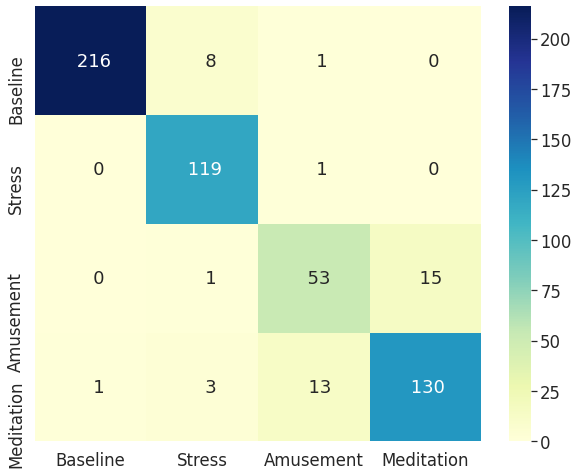

In [308]:
predicted_labels = model.predict(test_features)

confusion_matrix = np.zeros((4, 4))

for test_label, predicted_label in zip(test_labels, predicted_labels) :
    i = np.argmax(test_label)
    j = np.argmax(predicted_label)
    
    confusion_matrix[i][j] += 1

    
classes = ['Baseline', 'Stress', 'Amusement', 'Meditation']
df = pd.DataFrame(confusion_matrix, classes, classes)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt="4.0f", cmap="YlGnBu")

In [876]:
model.evaluate(test_features, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 0.7208 - accuracy: 0.6952


[0.7208217978477478, 0.6951871514320374]

In [1185]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=64,
    restore_best_weights=True,
    verbose=1
)

In [233]:
model_checkpoint_callback.

SyntaxError: invalid syntax (<ipython-input-233-84f5a96af3a0>, line 1)

In [239]:
data = tf.constant(np.arange(10).reshape(5, 2) * 10, dtype=tf.float32)

In [240]:
print(data)

tf.Tensor(
[[ 0. 10.]
 [20. 30.]
 [40. 50.]
 [60. 70.]
 [80. 90.]], shape=(5, 2), dtype=float32)


In [247]:
layer = tf.keras.layers.LayerNormalization(axis=0, scale=False)

In [248]:
output = layer(data)

In [249]:
print(output)

tf.Tensor(
[[-1.4142127  -1.4142127 ]
 [-0.70710635 -0.70710635]
 [ 0.          0.        ]
 [ 0.70710635  0.7071065 ]
 [ 1.4142127   1.4142128 ]], shape=(5, 2), dtype=float32)


In [798]:
a = np.divide(a, np.sum(a, axis=1))

In [794]:
a = [[1, 1], [2, 3]]

In [81]:
model.

TypeError: gradients_v2() missing 2 required positional arguments: 'ys' and 'xs'

In [1220]:
model.loss()

Object `model.loss()` not found.


In [1572]:
l = model.get_layer('spatial_dropout2d_341')

In [1573]:
l.rate = 0.2